In [151]:
from pyGDM2 import structures
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy.signal import find_peaks
from ase.io import read
import ase

sys.path.insert(0, 'Light/'); sys.path.insert(0, 'Building/')
from Light import Epsilon_ExpClass #For optical response with the pygdm package 

In [2]:
def Optimise(Step, g, m):
    Struct = structures.struct(Step, g, m, verbose = False, normalization="hex")

    while len(Struct.geometry) < len(g):
        Step -= 0.01
        Struct = structures.struct(Step, g, m, verbose = False, normalization="hex")
    return Struct


In [3]:
Strut = read("Structures/Ag_147.xyz")
ele = Strut.get_chemical_symbols()
Ele = list(set(ele))
Strut.positions -= Strut.get_center_of_mass()
xyz = Strut.positions
g = xyz
m = len(g)*[getattr(Epsilon_ExpClass, Ele[0])()]

Struct = Optimise(2.77, g, m)

In [4]:
field_generator = fields.plane_wave
wavelengths = np.linspace(300, 800, 201)

kwargs_L = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[-np.pi/2]) #Defines the left circularly polarized light coming in the xy plane along z in the positive direction
efield_L = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_L)
dyads = propagators.DyadsQuasistatic123(n1=1) #Vacuum
sim_L = core.simulation(Struct, efield_L, dyads)
sim_L.scatter(verbose=False)


kwargs_R = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[ np.pi/2]) #Defines the right circularly polarized light coming in the xy plane along z in the positive direction
efield_R = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs_R)
dyads = propagators.DyadsQuasistatic123(n1=1) #Vacuum
sim_R = core.simulation(Struct, efield_R, dyads)
sim_R.scatter(verbose=False)

1

In [ ]:
def specs_n_peaks(sim, chi = "L",
                  structure = None,
                  x = None,
                  y = None,
                  z = None,
                  ):
    
    if chi.upper() == "L":
        color = "blue"
        lab = "L"
    elif chi.upper() == "R":
        color = "red"
        lab = "R"
    
    field_kwargs = tools.get_possible_field_params_spectra(sim)
    wl, spectrum = tools.calculate_spectrum(sim,field_kwargs[0] , linear.extinct)

    spectrum = spectrum.T

    peaks, _ = find_peaks(spectrum[0], height=0.05*np.amax(spectrum[0]))

    _, Cspec = tools.calculate_spectrum(sim, 
                                        field_kwargs[0], 
                                        linear.optical_chirality, 
                                        r_probe=[[x,y,z]])

    
    if len(peaks) == 0:
        print("No significant peaks found.")
        return wl, spectrum, np.array([]), np.array([])
    else:
        print("Significant local maxima:")
        for peak in peaks:
            print(f"Value: {spectrum[0][peak]}, Index: {peak}")
            
            
        
        return wl, spectrum, peaks, wl[peaks], spectrum[0][peaks], color, lab, Cspec

In [116]:
L_CPL = specs_n_peaks(sim_L, "L",
                      structure=Struct,
                      x=np.amax(Struct.geometry[:,0]) + 1,
                      y=np.amax(Struct.geometry[:,1]) + 1,
                      z=np.amax(Struct.geometry[:,2]) + 1,
                      )
                      
R_CPL = specs_n_peaks(sim_R, "R",
                      structure=Struct,
                      x=np.amax(Struct.geometry[:,0]) + 1,
                      y=np.amax(Struct.geometry[:,1]) + 1,
                      z=np.amax(Struct.geometry[:,2]) + 1,
                      )

Significant local maxima:
Value: 488.50379878559664, Index: 21
Value: 775.8838084998551, Index: 26
Value: 353.861412740767, Index: 30
Value: 44.517703953056554, Index: 49
Value: 71.23902215922172, Index: 93
Significant local maxima:
Value: 488.50379878559664, Index: 21
Value: 775.8837028748333, Index: 26
Value: 353.8615669533173, Index: 30
Value: 44.51772676556673, Index: 49
Value: 71.23908550944026, Index: 93


In [170]:
def Plot_Ext_Spec(Save = False, Show = True):
    
    fig,axs = plt.subplots(ncols=1, nrows=2, figsize=(6,5), dpi=150, sharex=True)
    fig.subplots_adjust(wspace=0., hspace=0.)
    
    fig.set_dpi(150)
    
    axs[0].plot(L_CPL[0], L_CPL[1][0], color = L_CPL[5], label = "%s-CPL" %L_CPL[6])
    axs[0].scatter(L_CPL[3],L_CPL[4], color = L_CPL[5], marker = "o")

    for i,peak in enumerate(L_CPL[3]):
        axs[0].text(500, 0.85*np.amax(L_CPL[1][0])-0.15*np.amax(L_CPL[1][0])*i, 
                "$\lambda^{%s*}_{%s}$ = " f'{peak:.0f} nm' %(L_CPL[6],i), 
                ha='center', va='bottom', fontsize = 14)

    axs[0].plot(R_CPL[0], R_CPL[1][0], color = R_CPL[5], label = "%s-CPL" %R_CPL[6])
    axs[0].scatter(R_CPL[3],R_CPL[4], color = R_CPL[5], marker = "o")

    for i,peak in enumerate(R_CPL[3]):
        axs[0].text(700, 0.85*np.amax(R_CPL[1][0])-0.15*np.amax(R_CPL[1][0])*i, 
                "$\lambda^{%s*}_{%s}$ = " f'{peak:.0f} nm' %(R_CPL[6],i), 
                ha='center', va='bottom', fontsize = 14)
        
    axs[1].plot(L_CPL[0], L_CPL[-1]-2, color = L_CPL[5])
    axs[1].plot(R_CPL[0], R_CPL[-1]+2, color = R_CPL[5])
    
    axs[1].xaxis.set_major_locator(ticker.MultipleLocator(50))
    axs[0].set_ylabel(r'$\sigma$ [nm$^{2}$]', fontsize = 14)
    axs[1].set_ylabel(r'C / C$_{LCP}$ ', fontsize = 14)
    axs[1].set_xlabel(r'$\lambda$ [nm]', fontsize = 14)
    fig.legend(ncol = 2, bbox_to_anchor=(0.5, 0.9), loc='lower center', fontsize = 14,)
    
    if Save:
        plt.savefig(Save+".png", dpi = 150, bbox_inches='tight')
    elif Show:
        plt.show()
    else:
        plt.close()

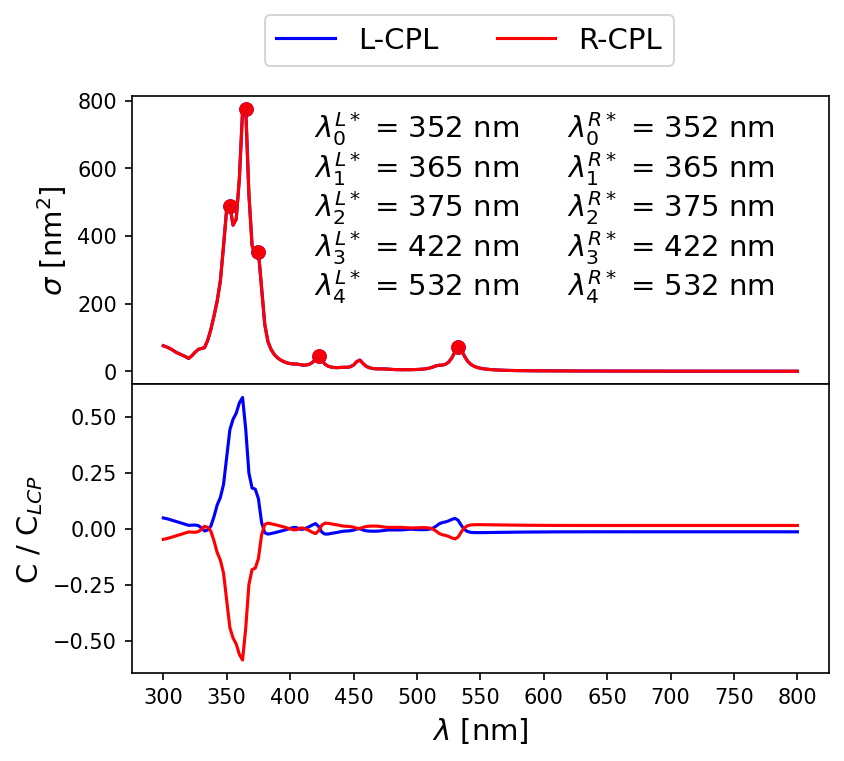

In [171]:
Plot_Ext_Spec()

In [220]:
def cmnp_plot(
              wl_target = 400, 
              z_probe = 0,
              projection = "XY",
              vmax_f = 100,
              vmax_c = 2
              ):
    
    idx = tools.get_closest_field_index(sim_L, dict(wavelength=wl_target))

    wl, Cspec_L = tools.calculate_spectrum(sim_L, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_L = Cspec_L.T
    
    r_probe_L = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_L_t = linear.optical_chirality(sim_L, idx, r_probe_L, which_field='t')
    
    C_L_t[-1] -= 2
    
    Es_L, Et_L, E0_L, Bs_L, Bt_L, B0_L  = linear.nearfield(sim_L, idx, r_probe=r_probe_L, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])
    E_max_L = np.amax(np.abs(Es_L[:,3].reshape(201,201))**2 + np.abs(Es_L[:,4].reshape(201,201))**2 + np.abs(Es_L[:,5].reshape(201,201))**2)
    wl, Cspec_R = tools.calculate_spectrum(sim_R, 0, linear.optical_chirality, r_probe=[[0,0,z_probe]])
    C_spec_R = Cspec_R.T
    
    
    r_probe_R = tools.generate_NF_map(-40,+40,201, -40,40,201, Z0=z_probe)
    C_R_t = linear.optical_chirality(sim_R, idx, r_probe_R, which_field='t')
    
    C_R_t[-1] += 2
    
    Es_R, Et_R, E0_R, Bs_R, Bt_R, B0_R  = linear.nearfield(sim_R, idx, r_probe=r_probe_R, which_fields=['es', 'et', 'e0', 'bs', 'bt', 'b0'])
    E_max_R = np.amax(np.abs(Es_R[:,3].reshape(201,201))**2 + np.abs(Es_R[:,4].reshape(201,201))**2 + np.abs(Es_R[:,5].reshape(201,201))**2)

    fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
    fig.set_size_inches(10, 10)
    fig.subplots_adjust(hspace=0.0, wspace=0.0)
    
    im_EL = visu.vectorfield_color(Et_L, show=0, ax=axs[0,0], cmap="viridis", vmin=0, 
                                   vmax = vmax_f, 
                                   projection=projection)
    #visu.structure_contour(sim_L, color='k', show=0, lw = 10, ax=axs[0,0], projection=projection)
    
    im_CL = visu.scalarfield(C_L_t, cmap='seismic', show=0, interpolation='nearest',  vmin=-vmax_c, vmax=vmax_c, ax=axs[1,0], projection=projection)
    #visu.structure_contour(sim_L, color='k', show=0, lw = 10, ax=axs[1,0], projection=projection)
    
    im_ER = visu.vectorfield_color(Et_R, show=0, ax=axs[0,1], cmap='viridis', vmin=0, 
                                   vmax = vmax_f,
                                   projection=projection)
    #visu.structure_contour(sim_R, color='k', show=0, lw = 10, ax=axs[0,1], projection=projection)
    
    im_CR = visu.scalarfield(C_R_t, cmap='seismic', show=0, interpolation='nearest', vmin=-vmax_c, vmax=vmax_c, ax=axs[1,1], projection=projection)
    #visu.structure_contour(sim_R, color='k', show=0, lw = 10, ax=axs[1,1], projection=projection)

    axs[0,1].yaxis.set_label_position("right")
    axs[0,1].yaxis.tick_right()
    
    axs[1,1].yaxis.set_label_position("right")
    axs[1,1].yaxis.tick_right()
    
    axs[0,0].xaxis.set_label_position("top")
    axs[0,0].xaxis.tick_top()
    
    axs[0,1].xaxis.set_label_position("top")
    axs[0,1].xaxis.tick_top()
    
    axs[0,1].tick_params(labeltop=True)
    axs[0,0].tick_params(labeltop=True)
    
    axs[0,1].tick_params(labelright=True)
    axs[1,1].tick_params(labelright=True)
    
    #fig.subplots_adjust(wspace=0.025, hspace=0.025)
    cbar_ax_cpl = fig.add_axes([0.125, 0.96, 0.725, 0.02])
    cax_cpl = fig.colorbar(im_ER, cax=cbar_ax_cpl,  orientation='horizontal')    
    cbar_ax_cpl.xaxis.set_ticks_position('top')
    
    cbar_ax_e = fig.add_axes([0.125, 0.025, 0.725, 0.02])
    cax_e = fig.colorbar(im_CR, cax=cbar_ax_e, orientation='horizontal')
    cbar_ax_e.xaxis.set_ticks_position('bottom')
    
    
    axs[0,0].text(0.5, 1.15, 'Left CPL', ha='center', va='center', fontsize = 16, transform=axs[0,0].transAxes)
    axs[0,1].text(0.5, 1.15, 'Right CPL', ha='center', va='center', fontsize = 16, transform=axs[0,1].transAxes)
    
    fig.text(0.5, 1.01,'$\mathcal{E}_{tot}^{2}$ / $\mathcal{E}_{0}^{2}$ ', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    fig.text(0.5, -0.01,'$\mathcal{C}_{tot}$ /$\mathcal{C}_{L}$', verticalalignment='center', horizontalalignment='center', fontsize = 16)
    axs[0,0].text(-45,50, f'$\lambda$ = ' f'{wl_target:.0f} nm', fontsize = 14)
    axs[0,1].text(17.5,50, f'z = {z_probe} nm', fontsize = 14)
    
    for ax in axs.flatten():
        for label in ax.get_xticklabels() + ax.get_yticklabels():
            label.set_rotation(45)
    
    axs = axs.T.flatten()
    for i,ax in enumerate(axs):
        for atom in Strut.positions:
            ax.scatter(atom[0], atom[1], color='k', s=500, marker='o', alpha  = 0.25)
        ax.set_aspect('equal')
    plt.show()
    

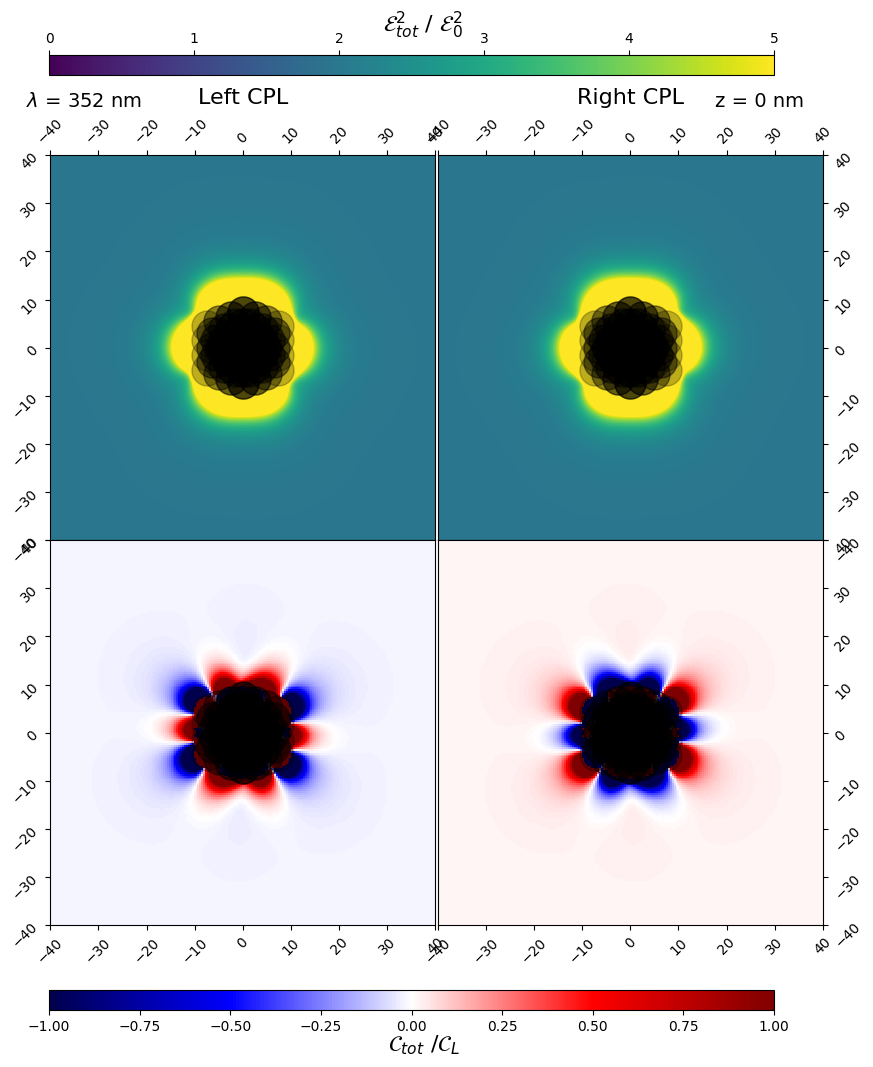

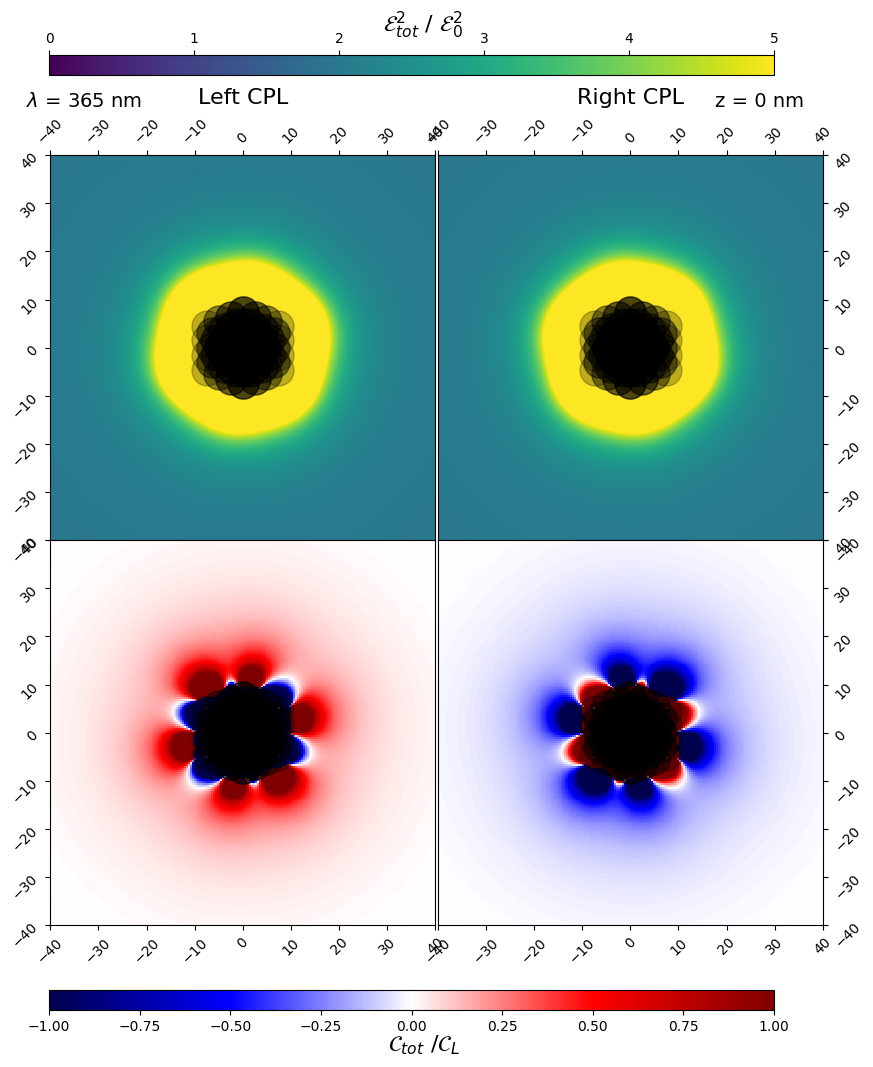

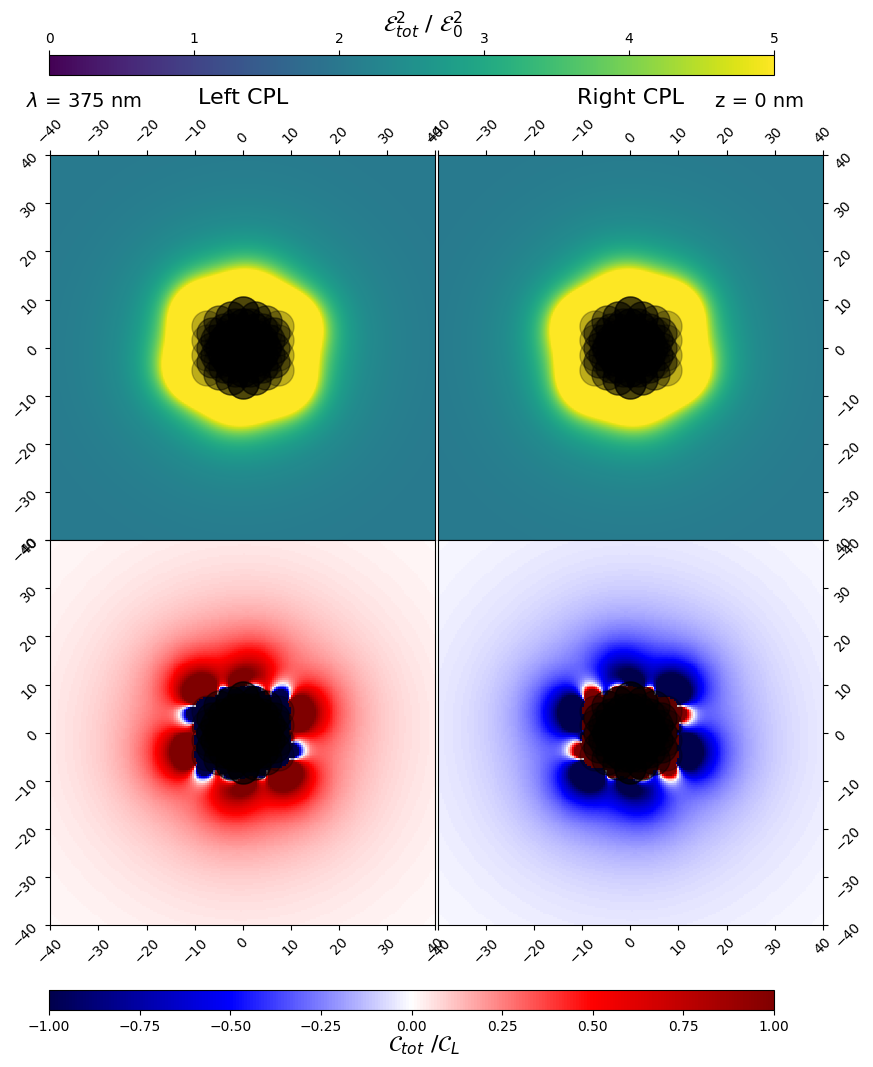

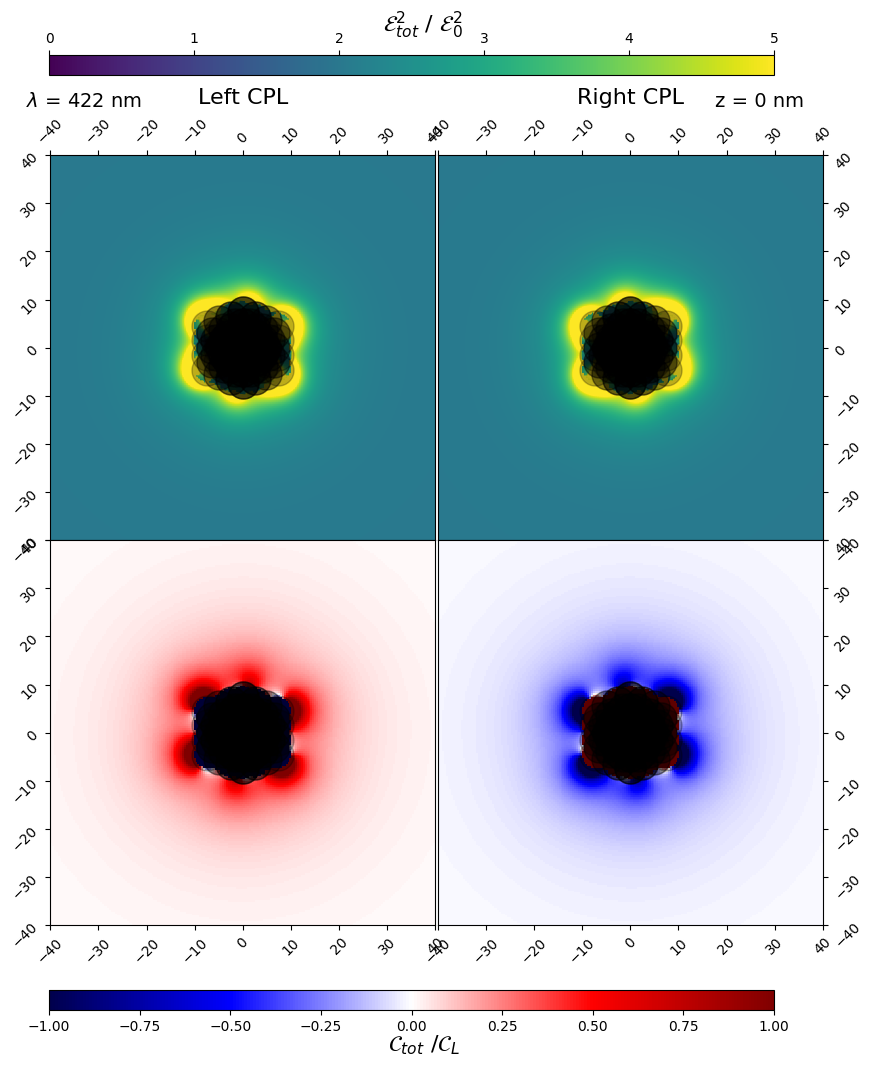

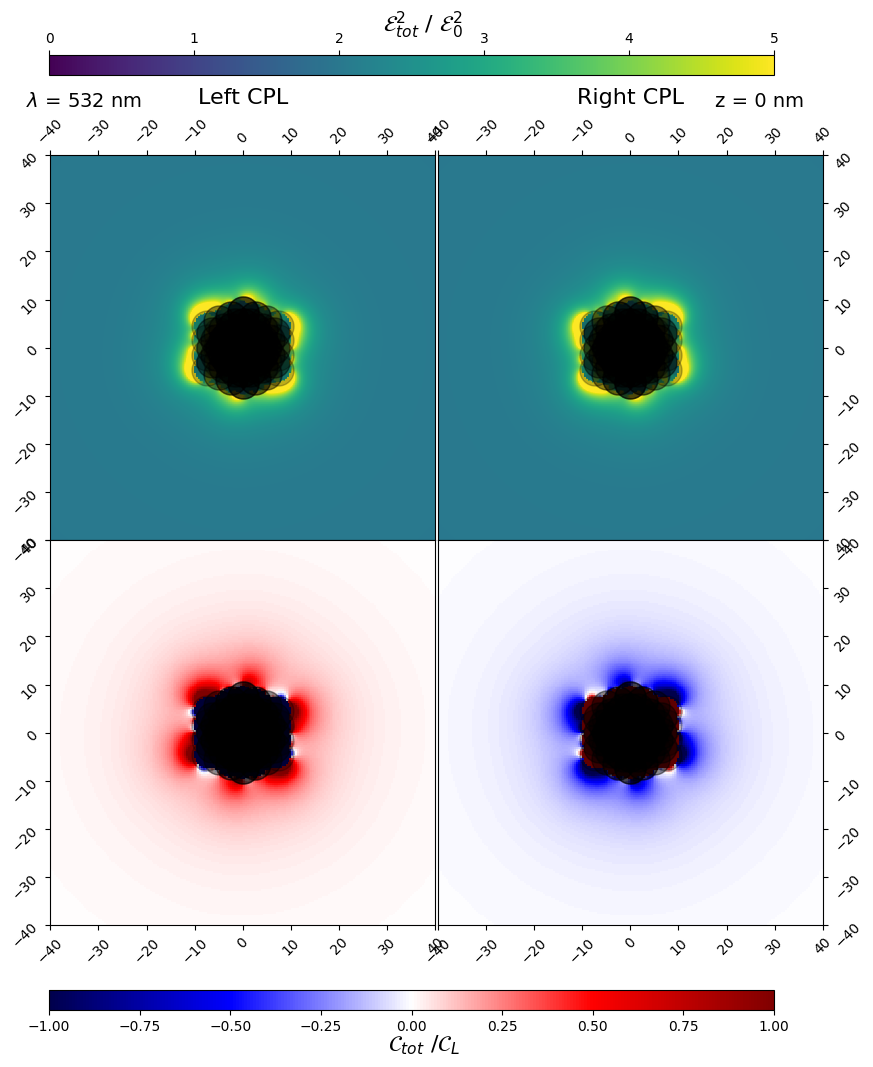

In [221]:
for peak in d:
    cmnp_plot(peak, 0, "XY", vmax_f = 5, vmax_c = 1)